this is a demo from reddit that implement mla on 2D image data, but why query not from data

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(42)

In [6]:
class SimpleEncoder(nn.Module):
    """
    A basic CNN encoder that extracts feature maps from an input image.
    Two convolutional layers with ReLU activations and max-pooling are used
    to reduce spatial dimensions.
    """
    def __init__(self, in_channels=3, feature_dim=64):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, feature_dim, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        return x

In [2]:
class LatentAttention(nn.Module):
    """
    This module learns a set of latent vectors (the experts) and refines them
    using multi-head attention on the input features.

    Input:
        x: A flattened feature tensor of shape [B, N, feature_dim],
           where N is the number of spatial tokens.
    Output:
        latent_output: The refined latent expert representations of shape [B, num_latents, latent_dim].
    """
    def __init__(self, feature_dim, latent_dim, num_latents, num_heads):
        super().__init__()
        self.num_latents = num_latents
        self.latent_dim = latent_dim
        self.latents = nn.Parameter(torch.randn(num_latents, latent_dim))
        self.key_proj = nn.Linear(feature_dim, latent_dim)
        self.value_proj = nn.Linear(feature_dim, latent_dim)
        self.query_proj = nn.Linear(latent_dim, latent_dim)
        self.attention = nn.MultiheadAttention(embed_dim=latent_dim, num_heads=num_heads, batch_first=True)

    def forward(self, x):
        B, N, _ = x.shape
        keys = self.key_proj(x)
        values = self.value_proj(x)
        queries = self.latents.unsqueeze(0).expand(B, -1, -1)
        queries = self.query_proj(queries)

        latent_output, _ = self.attention(query=queries, key=keys, value=values)
        return latent_output

In [3]:
class ExpertSegmentation(nn.Module):
    """
    For fine-grained segmentation, each pixel (or patch) feature first projects into the latent space.
    Then, it attends over the latent experts (the output of the LatentAttention module) to obtain a refined representation.
    Finally, a segmentation head projects the attended features to per-pixel class logits.

    Input:
        x: Flattened pixel features from the encoder [B, N, feature_dim]
        latent_experts: Latent representations from the attention module [B, num_latents, latent_dim]
    Output:
        logits: Segmentation logits [B, N, num_classes]
    """
    def __init__(self, feature_dim, latent_dim, num_heads, num_classes):
        super().__init__()
        self.pixel_proj = nn.Linear(feature_dim, latent_dim)
        self.attention = nn.MultiheadAttention(embed_dim=latent_dim, num_heads=num_heads, batch_first=True)
        self.segmentation_head = nn.Linear(latent_dim, num_classes)

    def forward(self, x, latent_experts):
        queries = self.pixel_proj(x)
        attn_output, _ = self.attention(query=queries, key=latent_experts, value=latent_experts)
        logits = self.segmentation_head(attn_output)
        return logits

In [4]:
class SegmentationModel(nn.Module):
    """
    The final model that ties together the encoder, latent attention module,
    and the expert segmentation head into one end-to-end trainable architecture.
    """
    def __init__(self, in_channels=3, feature_dim=64, latent_dim=64, num_latents=16, num_heads=4, num_classes=2):
        super().__init__()
        self.encoder = SimpleEncoder(in_channels, feature_dim)
        self.latent_attn = LatentAttention(feature_dim=feature_dim, latent_dim=latent_dim,
                                           num_latents=num_latents, num_heads=num_heads)
        self.expert_seg = ExpertSegmentation(feature_dim=feature_dim, latent_dim=latent_dim,
                                             num_heads=num_heads, num_classes=num_classes)

    def forward(self, x):
        features = self.encoder(x)
        B, F, H, W = features.shape
        features_flat = features.view(B, F, H * W).permute(0, 2, 1)
        latent_experts = self.latent_attn(features_flat)
        logits_flat = self.expert_seg(features_flat, latent_experts)
        logits = logits_flat.permute(0, 2, 1).view(B, -1, H, W)
        return logits

In [7]:
def generate_synthetic_data(batch_size, channels, height, width, num_classes):
    """
    Generates a batch of synthetic images and corresponding segmentation targets.
    The segmentation targets have lower resolution reflecting the encoder’s output size.
    """
    x = torch.randn(batch_size, channels, height, width)
    target_h, target_w = height // 4, width // 4
    y = torch.randint(0, num_classes, (batch_size, target_h, target_w))
    return x, y

batch_size = 4
channels = 3
height = 128
width = 128
num_classes = 2

model = SegmentationModel(in_channels=channels, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_iterations = 100
model.train()
for iteration in range(num_iterations):
    x_batch, y_batch = generate_synthetic_data(batch_size, channels, height, width, num_classes)
    optimizer.zero_grad()
    logits = model(x_batch)  # logits shape: [B, num_classes, H/4, W/4]
    loss = criterion(logits, y_batch)
    loss.backward()
    optimizer.step()
    if iteration % 10 == 0:
        print(f"Iteration {iteration}: Loss = {loss.item():.4f}")

Iteration 0: Loss = 0.6934
Iteration 10: Loss = 0.6932
Iteration 20: Loss = 0.6932
Iteration 30: Loss = 0.6932
Iteration 40: Loss = 0.6935
Iteration 50: Loss = 0.6933
Iteration 60: Loss = 0.6932
Iteration 70: Loss = 0.6931
Iteration 80: Loss = 0.6932
Iteration 90: Loss = 0.6932


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.243222..4.154193].


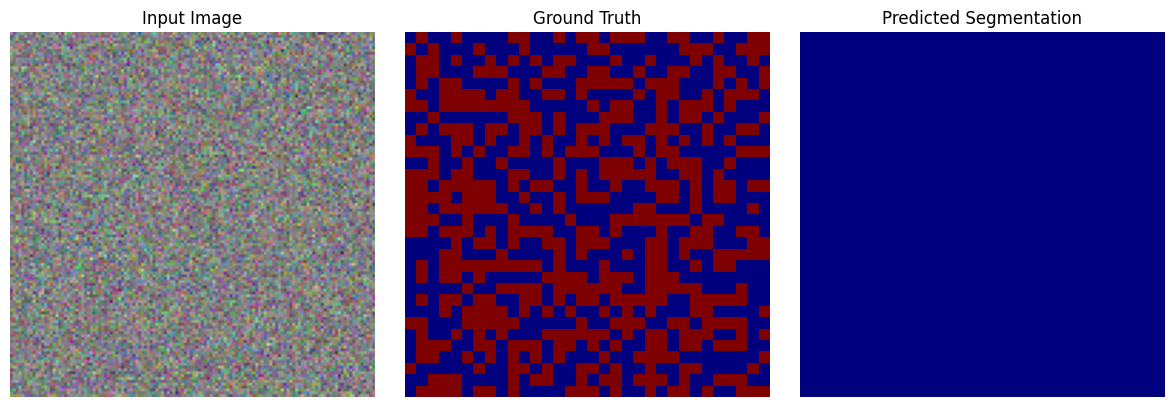

In [12]:
model.eval()
x_vis, y_vis = generate_synthetic_data(1, channels, height, width, num_classes)
with torch.no_grad():
    logits_vis = model(x_vis)
    pred = torch.argmax(logits_vis, dim=1)  # shape: [1, H/4, W/4]

img_np = x_vis[0].permute(1, 2, 0).numpy()
gt_np = y_vis[0].numpy()
pred_np = pred[0].numpy()

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(img_np)
axs[0].imshow((img_np - img_np.min()) / (img_np.max()-img_np.min()))
axs[0].set_title("Input Image")
axs[1].imshow(gt_np, cmap='jet')
axs[1].set_title("Ground Truth")
axs[2].imshow(pred_np, cmap='jet')
axs[2].set_title("Predicted Segmentation")
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()